In [1]:
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from datetime import datetime, timedelta
import pytz
import urllib.request
import ephem
import math
from matplotlib.animation import FFMpegWriter
from IPython.display import clear_output
from ephem import degree
from mpl_toolkits.basemap import Basemap

  Using cached pyproj-3.4.0-cp39-cp39-win_amd64.whl (4.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.5 which is incompatible.


      Successfully uninstalled numpy-1.21.5


In [20]:
count = 0
elem = ""
all_sats = []
with urllib.request.urlopen("http://celestrak.org/NORAD/elements/active.txt") as url:
    f = url.read()
    f = f.decode("utf-8") 
    for line in f.splitlines():
        elem += line + '\n'
        if (line[0] == '2'):
            elem = elem.strip()
            if elem.startswith("STARLINK"):
                lines = tuple(map(lambda x: x.strip(), elem.split('\n')))
                title = lines[0]
                line1 = lines[1]
                line2 = lines[2]
                all_sats.append({'body':ephem.readtle(title, line1, line2)})
                count += 1
            elem = ""

+600 seconds


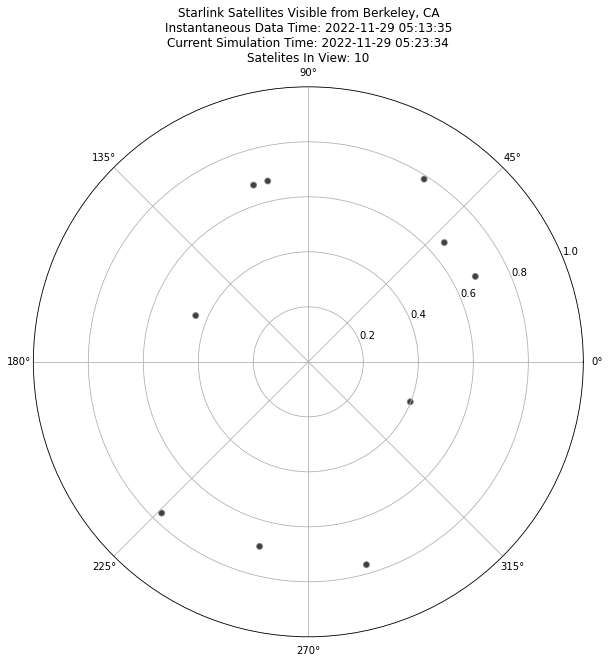

In [25]:
fig = plt.figure(1)
DPI = fig.get_dpi()
window_size = [1000, 1000]
berkeley = ephem.Observer()
berkeley.elevation = 15
berkeley.lat = '37.871593'
berkeley.lon = '-122.272743'
metadata = dict(title='Final Project video', artist='Will Minnis')
writer = FFMpegWriter(fps=30, metadata=metadata,bitrate=200000)

fig.set_size_inches(
    int(window_size[0]) / float(DPI),
    int(window_size[1]) / float(DPI))
sat_plt_idx = 0
curr_time = datetime.utcnow()
og_time = curr_time
with writer.saving(fig, "final.mp4", dpi=DPI):
    while(1):
        theta_plot = []
        radius_plot = []
        colors = []
        clear_output(wait=True)
        print(f"+{sat_plt_idx} seconds")
        if sat_plt_idx >= 600:
            break
        berkeley.date = curr_time
        count = 0
        for sat in all_sats:
            sat['body'].compute(berkeley)
            if math.degrees(sat['body'].alt) > 35:
                radius_plot.append(math.cos(sat['body'].alt))
                theta_plot.append(sat['body'].az)
                count += 1
                colors.append("#000000")
        ax = plt.subplot(111, polar=True)
        plt.subplots_adjust(left=0.05, right=0.6)
        ax.cla()
        ax.scatter(theta_plot, radius_plot, c=colors, edgecolors='#808080', alpha=0.75)
        ax.set_title(f"Starlink Satellites Visible from Berkeley, CA\nInstantaneous Data Time: {og_time.strftime('%Y-%m-%d %H:%M:%S')}\nCurrent Simulation Time: {curr_time.strftime('%Y-%m-%d %H:%M:%S')}\nSatelites In View: {count}")
        curr_time += timedelta(seconds=1)
        ax.set(ylabel=None)
        plt.draw()
        ax.set_ylim([0,1])
        writer.grab_frame()
        sat_plt_idx += 1

+900 seconds


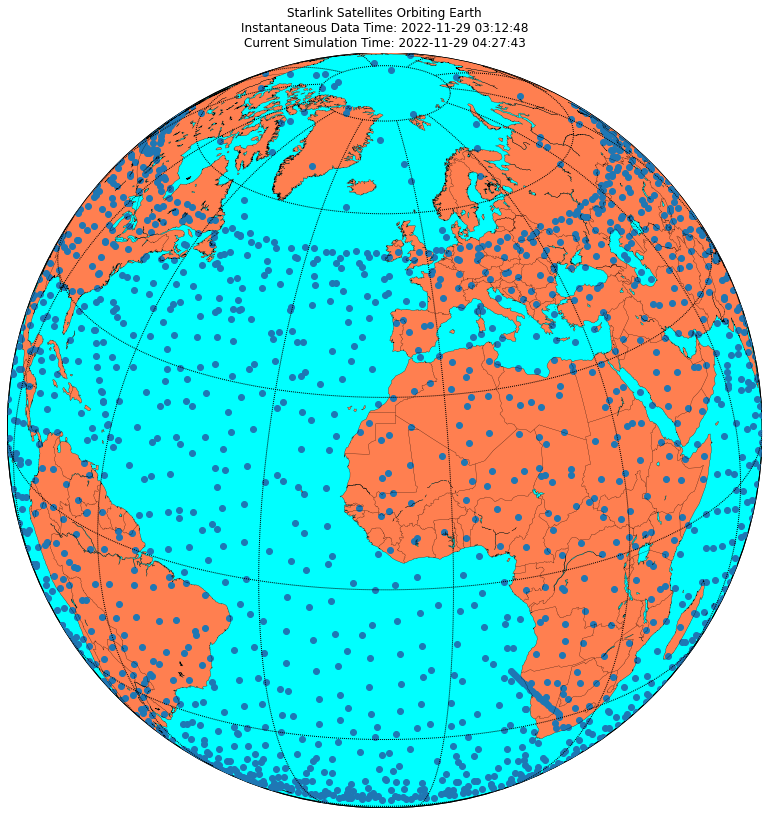

In [24]:
fig = plt.figure(1)
DPI = fig.get_dpi()
window_size = [1700, 1000]
lats = []
lons = []
metadata = dict(title='Final Project video', artist='Will Minnis')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)

fig.set_size_inches(
    int(window_size[0]) / float(DPI),
    int(window_size[1]) / float(DPI))
sat_plt_idx = 0
curr_time = datetime.utcnow()
og_time = curr_time
lon = -100
with writer.saving(fig, "final-globe.mp4", dpi=DPI):
    while(1):
        clear_output(wait=True)
        print(f"+{sat_plt_idx} seconds")
        if sat_plt_idx >= 900:
            break
        lats = []
        lons = []
        count = 0
        for sat in all_sats:
            sat['body'].compute(curr_time)
            lons.append(sat['body'].sublong/degree)
            lats.append(sat['body'].sublat/degree)
        ax = plt.subplot(111)
        ax.cla()
        # contour data over the map.
        bmap = Basemap(projection='ortho',lat_0=25,lon_0=lon,resolution='l')
        # draw coastlines, country boundaries, fill continents.
        bmap.drawcoastlines(linewidth=0.25)
        bmap.drawcountries(linewidth=0.25)
        bmap.fillcontinents(color='coral',lake_color='aqua')
        # draw the edge of the map projection region (the projection limb)
        bmap.drawmapboundary(fill_color='aqua')
        # draw lat/lon grid lines every 30 degrees.
        bmap.drawmeridians(np.arange(0,360,30))
        bmap.drawparallels(np.arange(-90,90,30))
        cs = bmap.scatter(lons, lats, latlon=True)
        ax.set_title(f"Starlink Satellites Orbiting Earth\nInstantaneous Data Time: {og_time.strftime('%Y-%m-%d %H:%M:%S')}\nCurrent Simulation Time: {curr_time.strftime('%Y-%m-%d %H:%M:%S')}")
        plt.draw()
        writer.grab_frame()
        curr_time += timedelta(seconds=5)
        lon += .5
        if lon == 180:
            lon *= -1
        sat_plt_idx += 1

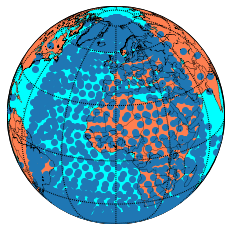

In [2]:
GM = 398600.4418

def stringScientificNotationToFloat(sn):
    "Specific format is 5 digits, a + or -, and 1 digit, ex: 01234-5 which is 0.01234e-5"
    return 0.00001*float(sn[5]) * 10**int(sn[6:])

def eccentricAnomalyFromMean(mean_anomaly, eccentricity, initValue,
                             maxIter=500, maxAccuracy = 0.0001):
    """Approximates Eccentric Anomaly from Mean Anomaly
       All input and outputs are in radians"""
    mean_anomaly = mean_anomaly
    e0 = initValue
    for x in range(maxIter):
        e1 = e0 - (e0 - eccentricity * sin(e0) - mean_anomaly) / (1.0 - eccentricity * cos(e0))
        if (abs(e1-e0) < maxAccuracy):
            break
    return e1

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [2]:
def plot_line(tle):
    "Returns commented information on a two line element"
    lines = tuple(map(lambda x: x.strip(), tle.split('\n')))
    title = lines[0]
    line1 = lines[1]
    line2 = lines[2]
    body = 
    print(body)
    satellite_number                                        = int(line1[2:7])
    classification                                          = line1[7:8]
    international_designator_year                           = int(line1[9:11])
    international_designator_launch_number                  = int(line1[11:14])
    international_designator_piece_of_launch                = line1[14:17]
    epoch_year                                              = int(line1[18:20])
    epoch                                                   = float(line1[20:32])
    first_time_derivative_of_the_mean_motion_divided_by_two = float(line1[33:43])
    second_time_derivative_of_mean_motion_divided_by_six    = stringScientificNotationToFloat(line1[44:52])
    bstar_drag_term                                         = stringScientificNotationToFloat(line1[53:61])
    the_number_0                                            = float(line1[62:63])
    element_number                                          = float(line1[64:68])
    checksum1                                               = float(line1[68:69])

    satellite        = int(line2[2:7])
    inclination      = float(line2[8:16])
    right_ascension  = float(line2[17:25])
    eccentricity     = float(line2[26:33]) * 0.0000001
    argument_perigee = float(line2[34:42])
    mean_anomaly     = float(line2[43:51])
    mean_motion      = float(line2[52:63])
    revolution       = float(line2[63:68])
    checksum2        = float(line2[68:69])

    # Inferred Epoch date
    year = 2000 + epoch_year if epoch_year < 70 else 1900 + epoch_year
    epoch_date = datetime(year=year, month=1, day=1, tzinfo=pytz.utc) + timedelta(days=epoch-1) # Have to subtract one day to get correct midnight

    # Time difference of now from epoch, offset in radians
    diff = datetime.now().replace(tzinfo=pytz.utc) + timedelta(hours=8) - epoch_date # Offset for PDT
    diff_seconds = 24*60*60*diff.days + diff.seconds + 1e-6*diff.microseconds # sec
    motion_per_sec = mean_motion * 2*pi / (24*60*60) # rad/sec
    offset = diff_seconds * motion_per_sec #rad
    mean_anomaly += offset * 180/pi % 360

    # Inferred period
    day_seconds = 24*60*60
    period = day_seconds * 1./mean_motion

    # Inferred semi-major axis (in km)
    semi_major_axis = ((period/(2*pi))**2 * GM)**(1./3)

    # Inferred true anomaly
    eccentric_anomaly = eccentricAnomalyFromMean(mean_anomaly * pi/180, eccentricity, mean_anomaly * pi/180)
    true_anomaly = 2*np.arctan2(sqrt(1+eccentricity) * sin(eccentric_anomaly/2.0), sqrt(1-eccentricity) * cos(eccentric_anomaly/2.0))
    # Convert to degrees
    eccentric_anomaly *= 180/pi
    true_anomaly *= 180/pi
    right_ascension += 90
    print(right_ascension)
    plot_orbit(semi_major_axis, eccentricity, inclination,
                           right_ascension, argument_perigee, true_anomaly, title)

In [3]:
def plot_orbit(semi_major_axis, eccentricity=0, inclination=0, 
              right_ascension=0, argument_perigee=0, true_anomaly=0, label=None):
    inc = inclination * pi / 180.;
    R = np.matrix([[1, 0, 0],
                   [0, cos(inc), -sin(inc)],
                   [0, sin(inc), cos(inc)]    ])
    rot = (right_ascension + argument_perigee) * pi/180
    R2 = np.matrix([[cos(rot), -sin(rot), 0],
                    [sin(rot), cos(rot), 0],
                    [0, 0, 1]    ])    
    theta = np.linspace(0,2*pi, 360)
    r = (semi_major_axis * (1-eccentricity**2)) / (1 + eccentricity*cos(theta))

    xr = r*cos(theta)
    yr = r*sin(theta)
    zr = 0 * theta

    pts = np.matrix(list(zip(xr,yr,zr)))
    pts =  (R * R2 * pts.T).T

    xr,yr,zr = pts[:,0].A.flatten(), pts[:,1].A.flatten(), pts[:,2].A.flatten()

    ax.plot(xr, yr, zr, '-')

    sat_angle = true_anomaly * pi/180
    satr = (semi_major_axis * (1-eccentricity**2)) / (1 + eccentricity*cos(sat_angle))
    satx = satr * cos(sat_angle)
    saty = satr * sin(sat_angle)
    satz = 0

    sat = (R * R2 * np.matrix([satx, saty, satz]).T ).flatten()
    satx = sat[0,0]
    saty = sat[0,1]
    satz = sat[0,2]

    c = np.sqrt(satx*satx + saty*saty)
    lat = np.arctan2(satz, c) * 180/pi
    lon = np.arctan2(saty, satx) * 180/pi
    
    # Draw radius vector from earth
    # ax.plot([0, satx], [0, saty], [0, satz], 'r-')
    # Draw red sphere for satellite
    #ax.plot([satx],[saty],[satz], 'ro')

    global max_radius
    max_radius = max(max(r), max_radius)

<ephem.EarthSatellite 'STARLINK-1007' at 0x0000025C7E06F8D0>


NameError: name 'stringScientificNotationToFloat' is not defined

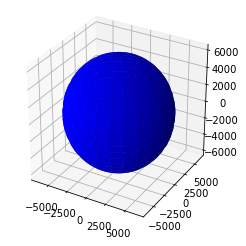

In [4]:
cos = np.cos
sin = np.sin
pi = np.pi
dot = np.dot
sqrt = np.sqrt
fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

max_radius = 0

Earth_radius = 6371 # km
max_radius = max(max_radius, Earth_radius)

# Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
coefs = (1, 1, 1)  

# Radii corresponding to the coefficients:
rx, ry, rz = [Earth_radius/np.sqrt(coef) for coef in coefs]

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

# Plot:
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b')
count = 0
elem = ""

with urllib.request.urlopen("http://celestrak.org/NORAD/elements/active.txt") as url:
    f = url.read()
    f = f.decode("utf-8") 
    for line in f.splitlines():
        elem += line + '\n'
        if count >= 50:
            break
        if (line[0] == '2'):
            elem = elem.strip()
            if elem.startswith("STARLINK"):
                lines = tuple(map(lambda x: x.strip(), elem.split('\n')))
                title = lines[0]
                line1 = lines[1]
                line2 = lines[2]
                all_sats.append(ephem.readtle(title, line1, line2))
                count += 1
            elem = ""

for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
plt.show()

In [20]:
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

TLE = """1 43205U 18017A   18038.05572532 +.00020608 -51169-6 +11058-3 0  9993
2 43205 029.0165 287.1006 3403068 180.4827 179.1544 08.75117793000017"""
L1, L2 = TLE.splitlines()

from skyfield.api import Loader, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

halfpi, pi, twopi = [f*np.pi for f in [0.5, 1, 2]]
degs, rads = 180/pi, pi/180

load = Loader('~/Documents/fishing/SkyData')
data = load('de421.bsp')
ts   = load.timescale()

planets = load('de421.bsp')
earth   = planets['earth']

Roadster = EarthSatellite(L1, L2)

print(Roadster.epoch.tt)
hours = np.arange(0, 3, 0.01)

time = ts.utc(2018, 2, 7, hours)

Rpos    = Roadster.at(time).position.km
Rposecl = Roadster.at(time).ecliptic_position().km

print(Rpos.shape)

re = 6378.

theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in [np.cos, np.sin, np.zeros_like]]
lon0 = re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in [np.cos, np.sin]]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in [np.cos, np.sin]]
    lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)

if True:    
    fig = plt.figure(figsize=[10, 8])  # [12, 10]

    ax  = fig.add_subplot(1, 1, 1, projection='3d')

    x, y, z = Rpos
    ax.plot(x, y, z)
    for x, y, z in lons:
        ax.plot(x, y, z, '-k')
    for x, y, z in lats:
        ax.plot(x, y, z, '-k')

    centers, hw = makecubelimits(ax)

    print("centers are: ", centers)
    print("hw is:       ", hw)

    plt.show()

r_Roadster = np.sqrt((Rpos**2).sum(axis=0))
alt_roadster = r_Roadster - re

if True:
    plt.figure()
    plt.plot(hours, r_Roadster)
    plt.plot(hours, alt_roadster)
    plt.xlabel('hours', fontsize=14)
    plt.ylabel('Geocenter radius or altitude (km)', fontsize=14)
    plt.show()

ModuleNotFoundError: No module named 'skyfield'